In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters

cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.0005

<b>Considered network

<!-- ![image.png](https://raw.githubusercontent.com/antoniovitorvb/IST-data-analytics-for-smart-grids/main/project1/DASG%20project1%20topology.png) -->

<img src='https://raw.githubusercontent.com/antoniovitorvb/IST-data-analytics-for-smart-grids/main/project1/DASG-project1_topology3.png' alt='topology.png' width=400 height='auto'>

<b>Initial Data

In [160]:
#Consumption dataset
s = [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

newConsumers = 6
S = s.copy()
newCol = []
np.random.seed(120)
for i in range(newConsumers):
    flat_S = S.flatten()
    samples = np.random.choice(flat_S, size=m+1, replace=True)
    new_column = samples + np.random.normal(loc=0, scale=noiseFactor**2, size=len(samples))
    new_column = np.round(new_column, 3)

    S = np.c_[S, new_column]
    # S.append()

#topology
topo=[[1,2], [2,3], [3,4], [4,5], [5,6], [6,7]]
nBUS=np.max(topo)

#Impedance
z = []
for i in range(len(topo)):
    r = np.round(np.random.uniform(low=0.01, high=0.25), 3)
    im = np.round(np.random.uniform(low=0.01, high=0.15), 3)

    z.append(complex(r, im))

z = np.multiply(z, netFactor)
# print(z)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow

print('\nApparent power with new consumers:\n', S)


Apparent power with new consumers:
 [[0.045 0.015 0.047 0.033 0.016 0.024 0.028 0.02  0.259 0.02 ]
 [0.025 0.015 0.248 0.033 0.045 0.015 0.02  0.028 0.394 0.028]
 [0.097 0.025 0.394 0.033 0.028 0.022 0.016 0.015 0.017 0.024]
 [0.07  0.049 0.02  0.485 0.016 0.02  0.015 0.201 0.024 0.015]
 [0.125 0.046 0.016 0.143 0.394 0.07  0.026 0.049 0.046 0.015]
 [0.29  0.027 0.016 0.047 0.049 0.206 0.049 0.015 0.033 0.015]
 [0.259 0.015 0.017 0.02  0.29  0.045 0.047 0.046 0.015 0.206]
 [0.259 0.016 0.028 0.016 0.026 0.026 0.206 0.097 0.047 0.046]
 [0.442 0.016 0.05  0.017 0.13  0.028 0.394 0.046 0.049 0.016]
 [0.201 0.023 0.046 0.016 0.047 0.143 0.046 0.017 0.049 0.097]
 [0.206 0.049 0.022 0.024 0.016 0.026 0.049 0.022 0.046 0.026]
 [0.13  0.047 0.016 0.049 0.143 0.022 0.046 0.259 0.025 0.046]
 [0.046 0.026 0.017 0.048 0.259 0.016 0.13  0.016 0.017 0.097]]


<b>Power Flow Function

In [161]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    nBUS=np.max(t)
    
    # w=len(p)
    # vp=np.zeros(si.shape, dtype=complex)
    # vn=np.zeros(si.shape, dtype=complex)
    w=len(p)+1
    vp=np.zeros((3,w), dtype=complex)
    vn=np.zeros((3,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2, 4):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va = vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si, np.abs(va)**el), va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            # return mvp
            return mvp, ip, inn
            
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration

In [162]:
seed = 0
while True:
    np.random.seed(seed)

    consumerPhase = np.array(np.random.randint(0, 3, size=S.shape[1]))
    consumerBus = np.array(np.random.randint(1, nBUS, size=S.shape[1]))
    # print(np.unique(consumerPhase, return_counts=True))
    # print(np.unique(consumerBus))

    # Phase-Bus coordinates
    coordinates = np.vstack((consumerPhase, consumerBus)).T
    unique_coordinates, indices, counts = np.unique(coordinates, axis=0, return_index=True, return_counts=True)

    # Check if any coordinate pairs are repeated
    is_repeated = len(coordinates) == len(unique_coordinates)
    all_phases = np.min(np.unique(consumerPhase, return_counts=True)[1]) >= 2 # min of 2 consumers per phase
    # all_buses = len(np.unique(consumerBus)) == nBUS
    all_buses = len(np.unique(consumerBus)) >= 6 # alternative threshold

    if is_repeated and all_phases and all_buses:
        print('right seed =', seed)
        print(consumerPhase)
        print(consumerBus)
        break
    else:
        seed+=1

right seed = 6
[2 1 0 2 1 2 0 2 1 1]
[4 6 2 3 2 5 5 2 1 3]


In [163]:
pd.DataFrame(si)

,0,1,2,3,4,5,6
0,0.0,0.000,0.016,0.000,0.00,0.046,0.000
1,0.0,0.025,0.143,0.046,0.00,0.000,0.047
2,0.0,0.000,0.259,0.049,0.13,0.022,0.000


In [164]:
#Creation of Matrices
al = np.exp(-1j * np.deg2rad(120)) # Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
I=np.zeros((m, nBUS), dtype=complex)
dv_abs=np.zeros((m,3))

# Assign each consumer to one Phase and one Bus:
np.random.seed(seed)
consumerPhase = np.array(np.random.randint(0, 3, size=S.shape[1]))  # 0 = a; 1 = b; 2 = c
consumerBus = np.array(np.random.randint(1, nBUS, size=S.shape[1])) # except the source (n)

# print(consumerPhase)
# print(consumerBus)

for i in range(m):
    si = np.zeros((3, nBUS))
    for c in range(S.shape[1]):
        si[consumerPhase[c], consumerBus[c]] = S[i, c]
    # print('\n',S[i,:])
    # print('SI values:\n', pd.DataFrame(si))
    
    mvp, Ip, Inn = pf3ph(topo,z,si,vr,el,ni,al)
    # mvp = pf3ph(topo,z,si,vr,el,ni,al)
    # print('\nMVP:\n', pd.DataFrame(mvp))
    noise = 1 + noiseFactor*np.random.randn(mvp.shape[0], mvp.shape[1])
    mvp = np.multiply(mvp, noise)  # Add noise to the currents
    noise = 1 + noiseFactor*np.random.randn(Ip.shape[0], Ip.shape[1])
    Ip = np.multiply(Ip, noise)  # Add noise to the currents

    Y[3*(i):3*(i)+3]=mvp[:, -1]                 # Save Vq in matrix Y
    I[i] = np.sum(Ip, axis=0)                   # Save unknown-phase loads of the nodes
    dv_abs[i,:]=vr-np.abs(mvp[:,-1])            # Voltage variations (only to plot)

Volt=np.reshape(Y,(m, 3))

print ('The voltages measured (Vq) in the PMUs are:\n', Volt)
print ('\nThe unknown-phase loads measured in the PMUs are:\n', I)

The voltages measured (Vq) in the PMUs are:
 [[ 0.99459673-0.00720244j -0.50658911-0.85375028j -0.47974136+0.85642716j]
 [ 0.96636215-0.01348109j -0.52920458-0.84622287j -0.50365208+0.86099584j]
 [ 0.97375654-0.03793861j -0.50271259-0.87335721j -0.47430876+0.83473522j]
 [ 1.06933018-0.03819471j -0.42897293-0.88529141j -0.3419116 +0.78277375j]
 [ 1.03662372+0.00383739j -0.46505515-0.81650067j -0.40254436+0.84567182j]
 [ 1.07250417-0.05652405j -0.42123079-0.90228778j -0.32210936+0.76224168j]
 [ 1.03418864+0.00362389j -0.46234624-0.8037014j  -0.39862355+0.84467813j]
 [ 0.97638237-0.07328033j -0.48738862-0.89851132j -0.42570766+0.79141319j]
 [ 0.92798252-0.12775527j -0.4982959 -0.92758867j -0.4076475 +0.7430502j ]
 [ 1.04050842-0.0286803j  -0.45358523-0.86347682j -0.38270679+0.81083832j]
 [ 1.02090122-0.02164927j -0.47348553-0.86201179j -0.42457175+0.82890298j]
 [ 1.02620418-0.01113174j -0.46974033-0.84093991j -0.41621866+0.8376087j ]]

The unknown-phase loads measured in the PMUs are:
 [[

<b>Voltage deviation in Q

In [165]:
dVq=np.zeros(3*m, dtype=complex)
dVq_abs=np.zeros(3*m, dtype=complex)

#Compute dVq for each time period m   
for i in range (m):
    dVq[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    dVq_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info

print('dVq\n', dVq)
print('\n Absolute dVq\n', dVq_abs)

dVq
 [ 0.00540327+0.00720244j  0.00658911-0.01227512j -0.02025864+0.00959824j
  0.03363785+0.01348109j  0.02920458-0.01980253j  0.00365208+0.00502957j
  0.02624346+0.03793861j  0.00271259+0.00733181j -0.02569124+0.03129018j
 -0.06933018+0.03819471j -0.07102707+0.01926601j -0.1580884 +0.08325165j
 -0.03662372-0.00383739j -0.03494485-0.04952474j -0.09745564+0.02035358j
 -0.07250417+0.05652405j -0.07876921+0.03626237j -0.17789064+0.10378373j
 -0.03418864-0.00362389j -0.03765376-0.06232401j -0.10137645+0.02134728j
  0.02361763+0.07328033j -0.01261138+0.03248591j -0.07429234+0.07461221j
  0.07201748+0.12775527j -0.0017041 +0.06156326j -0.0923525 +0.1229752j
 -0.04050842+0.0286803j  -0.04641477-0.00254859j -0.11729321+0.05518709j
 -0.02090122+0.02164927j -0.02651447-0.00401361j -0.07542825+0.03712243j
 -0.02620418+0.01113174j -0.03025967-0.02508549j -0.08378134+0.0284167j ]

 Absolute dVq
 [ 0.00537719+0.j         -0.00363268-0.00629199j -0.00917945+0.01589927j
  0.03354382+0.j         -0.00

<b>Complex Expansion

<img src='https://raw.githubusercontent.com/antoniovitorvb/IST-data-analytics-for-smart-grids/main/project1/complex_expansion.png' alt='regression.png' width=500 height='auto'>

In [172]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm; z_ml and z_lk
Z = np.array([[2, al, al**2],
              [1, 2*al, al**2],
              [1, al, 2*al**2]])

X = np.zeros((len(Y), 3*S.shape[1]), dtype=complex)
for t in range(m):
    for c in range(S.shape[1]):
        X[3*t:3*t+3, 3*c:3*c+3] = np.dot(Z, np.sum(z[:consumerBus[c]]) * S[t, c])

<b>Betas with PMUs

In [230]:
phase_dict = {
    0: 'a',
    1: 'b',
    2: 'c'
}

xTx = np.linalg.inv(X.conj().T @ X)
betaPMU = xTx @ np.transpose(X.conj()) @ dVq

B = pd.DataFrame(np.real(betaPMU).reshape(10,3))
B.columns = ['a', 'b', 'c']
B.index = [f'Consumer {c+1}' for c in range(len(B))]
B['original_phase'] = [phase_dict[p] for p in consumerPhase]
B['phase_PMU'] = [phase_dict[p] for p in np.argmax(np.round(np.real(betaPMU), 3).reshape(10,3), axis=1)]
B

,a,b,c,original_phase,phase_PMU
Consumer 1,0.009290,0.005663,0.977057,c,c
Consumer 2,-0.011487,0.976784,0.071104,b,b
Consumer 3,1.007528,0.003565,-0.001855,a,a
Consumer 4,0.020520,-0.003442,0.999093,c,c
Consumer 5,-0.005470,0.981896,-0.013896,b,b
Consumer 6,-0.005830,0.002989,1.007605,c,c
Consumer 7,0.982869,-0.001279,0.038056,a,a
Consumer 8,0.014274,0.034505,0.966741,c,c
Consumer 9,0.047888,0.977126,-0.070115,b,b
Consumer 10,-0.008262,0.996007,0.039184,b,b


In [229]:
[f'Consumer {c+1}' for c in range(len(B))]

['Consumer 1',
 'Consumer 2',
 'Consumer 3',
 'Consumer 4',
 'Consumer 5',
 'Consumer 6',
 'Consumer 7',
 'Consumer 8',
 'Consumer 9',
 'Consumer 10']

In [231]:
xTx = np.linalg.inv(X.conj().T @ X)
betaRTU = xTx @ np.transpose(X.conj()) @ dVq_abs

Brtu = pd.DataFrame(np.real(betaRTU).reshape(10,3))
Brtu.columns = ['a', 'b', 'c']
Brtu.index = [f'Consumer {c+1}' for c in range(len(Brtu))]
Brtu['original_phase'] = [phase_dict[p] for p in consumerPhase]
Brtu['phase_RTU'] = [phase_dict[p] for p in np.argmax(np.round(np.real(betaRTU), 3).reshape(10,3), axis=1)]
Brtu

,a,b,c,original_phase,phase_RTU
Consumer 1,-0.588600,0.275787,0.906967,c,c
Consumer 2,0.534321,0.935516,-0.698005,b,b
Consumer 3,0.725322,-0.538647,0.433178,a,a
Consumer 4,-0.552983,0.330179,0.860228,c,c
Consumer 5,0.484774,0.713358,-0.600817,b,b
Consumer 6,-0.578795,0.441016,0.709861,c,c
Consumer 7,0.721635,-0.451062,0.387178,a,a
Consumer 8,-0.599200,0.357129,0.790065,c,c
Consumer 9,0.251790,-0.337977,0.087047,b,a
Consumer 10,0.449521,0.953903,-0.587514,b,b


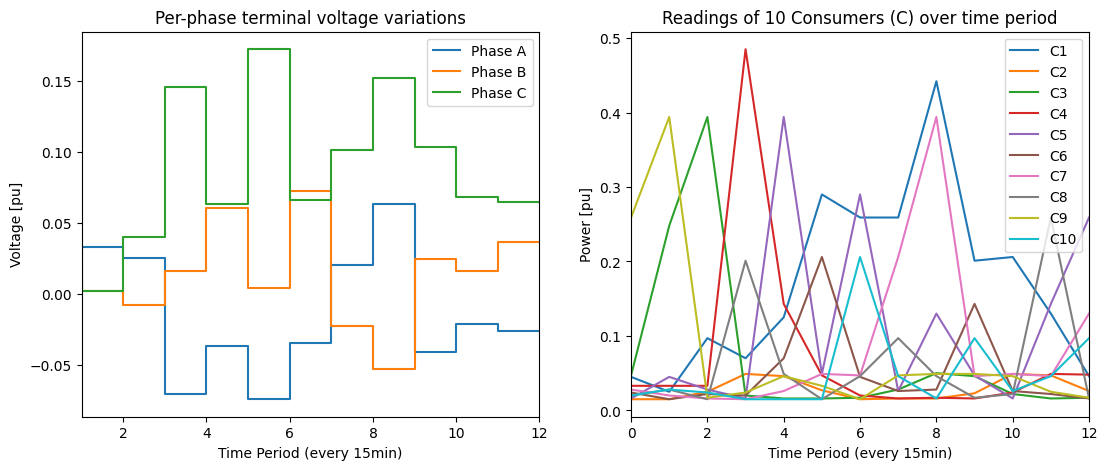

In [226]:
x = np.arange(m)
y1 = dv_abs
y2 = S

time_steps = np.arange(1, 13)

# Plot each phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot for the first subplot
ax1.step(time_steps, y1[:, 0], label='Phase A')
ax1.step(time_steps, y1[:, 1], label='Phase B')
ax1.step(time_steps, y1[:, 2], label='Phase C')
ax1.set_xlabel('Time Period (every 15min)')
ax1.set_ylabel('Voltage [pu]')
ax1.set_title('Per-phase terminal voltage variations')
ax1.legend()
ax1.set_xlim(1, 12)

# Plot for the second subplot
for c in range(S.shape[1]):
    ax2.plot(np.arange(13), y2[:, c], label=f'C{c+1}')

ax2.set_xlabel('Time Period (every 15min)')
ax2.set_ylabel('Power [pu]')
ax2.set_title(f'Readings of {S.shape[1]} Consumers (C) over time period')
ax2.legend()
ax2.set_xlim(0, 12)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()